In [1]:
import datetime
import collections
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
from keras.layers import Concatenate, BatchNormalization, Bidirectional
from keras.layers import SimpleRNN, Input, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.text import Tokenizer
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

C:\Users\ariaq\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
stop_words = stopwords.words('english')
stemmer = nltk.SnowballStemmer("english")


def read_train():
    train = pd.read_csv(
        './tweet-sentiment-extraction/train.csv').dropna()
    train['text'] = train['text']
    train['selected_text'] = train['selected_text']
    return train


def read_test():
    test = pd.read_csv('./tweet-sentiment-extraction/test.csv').dropna()
    test['text'] = test['text']
    return test


def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    text = str(text).lower()
    pat = r"[{}]".format(string.punctuation) # create the pattern
    text = re.sub(pat, ' ', text) # remove punctuation
    text = re.sub('  +', ' ', text) # remove spaces
    text = re.sub('https?://|www\.', '', text)  # remove urls
    # text = re.sub('<.*?>', '', text) 
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) # remove digits
    return text


def preprocess_data(text):
    """
       Clean puntuation, urls, and so on, 
       removing stop-words and make stemming
    """
    text = text if clean_text(text)==0 else clean_text(text)
    # Remove stop-words
    text = ' '.join(word for word in text.split()
                    if word not in stop_words)    # Remove stopwords
    # Stemm all the words in the sentence
    # text = ' '.join(stemmer.stem(word) for word in text.split())
    return text


def wrong_words(text, selected):
    words = []
    text = text.split()
    selected = selected.split()
    for i in selected:
        if i not in text:
            words.append(i)
    if len(words) > 0:
        return " ".join(words)
    else:
        return '++++'


def remove_text(x):
    selected = x[0]
    spelling = x[1]
    selected = selected.split()
    selected.remove(spelling)
    return " ".join(selected)


def remove_text_end(x):
    selected = x[0]
    spelling = x[1]
    selected = selected.split()
    if selected[-1] == spelling:
        selected.remove(spelling)
    return " ".join(selected)


def matching(x, tg):
    text = x[0]
    selected = x[1]
    spelling = x[2]
    text = text.split()
    selected = selected.split()
    spelling = spelling.split()
    for s in spelling:
        for t in text:
            if s in selected:
                if(fuzz.ratio(t, s) > tg):
                    index = selected.index(s)
                    selected[index] = t
    return " ".join(selected)


def start_index(x):
    text = x[0]
    selected = x[1]
    text = text.split()
    selected = selected.split()
    try:
        word = selected[0]
        index = text.index(word)
    except:
        index = 0
    return index


def end_index(x):
    text = x[0]
    selected = x[1]
    start_index = x[2]
    text = text.split()
    selected = selected.split()
    word = selected[-1]
    try:
        index = text.index(word, start_index)
    except:
        try:
            index = text.index(word)
        except:
            index = len(text) - 1
    return index


def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


def get_text(x):
    pred = []
    text = x[0]
    index = x[1]
    text = text.split()
    l = len(text)
    for i in index:
        if i < l:
            pred.append(text[i])
    return pred

In [3]:
train = read_train()
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
test = read_test()
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [5]:
train['clean_text'] = train['text'].apply(preprocess_data)
train['clean_selected'] = train['selected_text'].apply(preprocess_data)
test['clean_text'] = test['text'].apply(preprocess_data)

In [6]:
print(train[train["clean_text"] == ' ']['clean_text'].count())
print(train[train["clean_selected"] == ' ']['clean_selected'].count())
train.drop(train[train["clean_text"] == ' '].index, inplace=True)
train.drop(train[train["clean_selected"] == ' '].index, inplace=True)

0
0


In [7]:
train['spelling'] = train.apply(
    lambda x: wrong_words(x.clean_text, x.clean_selected), axis=1)
train[train['spelling'] == '++++'].count()

textID            26551
text              26551
selected_text     26551
sentiment         26551
clean_text        26551
clean_selected    26551
spelling          26551
dtype: int64

In [8]:
train[train['spelling'].apply(lambda x: len(x)) <= 2]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling
39,2863f435bd,A little happy for the wine jeje ok it`sm my f...,A little happy fo,positive,little happy wine jeje ok sm free time cares j...,little happy fo,fo
48,3d9d4b0b55,"i donbt like to peel prawns, i also dont like ...",dont like go,negative,donbt like peel prawns also dont like going sh...,dont like go,go
134,6903cb08f2,Nice to see you tweeting! It`s Sunday 10th M...,e nice,positive,nice see tweeting sunday may celebrating mothe...,e nice,e
166,c78bf59e67,#lichfield #tweetup sounds like fun Hope to...,p sounds like fun,positive,lichfield tweetup sounds like fun hope see eve...,p sounds like fun,p
197,e651d415c6,nite nite bday girl have fun at concert,e fun,positive,nite nite bday girl fun concert,e fun,e
...,...,...,...,...,...,...,...
27240,40143b692e,who knows It makes me sad lol,e sad,negative,knows makes sad lol,e sad,e
27302,90c8aa60db,Have I ever told you I absolutly hate writing ...,hate wr,negative,ever told absolutly hate writing emails status...,hate wr,wr
27349,f60f20ed09,"yea but that`s an old pic, she looks a lot d...","yea but that`s an old pic, she looks a lot di...",neutral,yea old pic looks lot different turned beautif...,yea old pic looks lot different turned beautif...,lo
27456,d32efe060f,i wanna leave work already! Not feelin it 2day,wanna leave work al,negative,wanna leave work already feelin,wanna leave work al,al


In [9]:
train['clean_selected'] = train[['clean_selected', 'spelling']].apply(
    lambda x: remove_text(x) if len(x['spelling']) <= 2 else x['clean_selected'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.clean_text, x.clean_selected), axis=1)
train[train['spelling'] == '++++'].count()

textID            27144
text              27144
selected_text     27144
sentiment         27144
clean_text        27144
clean_selected    27144
spelling          27144
dtype: int64

In [10]:
train['len_cl_txt'] = train['clean_text'].apply(lambda x: len(x))
train['len_cl_sel'] = train['clean_selected'].apply(lambda x: len(x))

In [11]:
# Check lenght on text and selected text
train[train['len_cl_txt'] < train['len_cl_sel']]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel
1363,4eec486ad7,"hey i loved ACS but i had to see it online, i...","y i loved ACS but i had to see it online, is n...",positive,hey loved acs see online yet cant wait buy loo...,loved acs see online yet cant wait buy look am...,ther,55,56
2785,cf9cdcdf32,well that does make me feel better about stay...,well that does make me feel better about stayi...,neutral,well make feel better staying even later watch...,well make feel better staying even later watch...,agai,67,72
6033,7753817baa,Yep still a few seats left for PRACC workshop...,Yep still a few seats left for PRACC workshop ...,neutral,yep still seats left pracc workshop w http bit...,yep still seats left pracc workshop w http bit...,ther,53,58
6176,3a3d4dcf4a,ack ~ of course i`m a person! but i think k...,ack ~ of course i`m a person! but i think kno...,neutral,ack course person think knows,ack course person think knows tha,tha,29,33
18622,5de31bf0bd,aww i know its my addiction! awww i know sa...,aww i know its my addiction! awww i know sam...,neutral,aww know addiction awww know sameee,aww know addiction awww know sameee mor,mor,35,39
19985,7de9e9769b,Just saw a male Baltimore oriole at our suet f...,ust saw a male Baltimore oriole at our suet fe...,neutral,saw male baltimore oriole suet feeder somethin...,ust saw male baltimore oriole suet feeder some...,ust,92,96
21018,79f5ba757b,just got back from tori`s. watching shark boy ...,ust got back from tori`s. watching shark boy a...,neutral,got back tori watching shark boy lava girl,ust got back tori watching shark boy lava girl,ust,42,46
22717,ce8c23ca6f,what I said! I`ll have to think about it ...,what I said! I`ll have to think about it an...,neutral,said think try,said think try aga,aga,14,18


In [12]:
train.loc[train['len_cl_txt'] < train['len_cl_sel'], 'clean_selected'] = train.loc[train['len_cl_txt'] < train['len_cl_sel'], 'clean_text']
train['spelling'] = train.apply(
    lambda x: wrong_words(x.clean_text, x.clean_selected), axis=1)
print(train[train['spelling'] == '++++'].count())
train['len_cl_txt'] = train['clean_text'].apply(lambda x: len(x))
train['len_cl_sel'] = train['clean_selected'].apply(lambda x: len(x))
train[train['len_cl_txt'] < train['len_cl_sel']]

textID            27152
text              27152
selected_text     27152
sentiment         27152
clean_text        27152
clean_selected    27152
spelling          27152
len_cl_txt        27152
len_cl_sel        27152
dtype: int64


,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel


In [13]:
print(fuzz.ratio('geeksforgeeks', 'geeksgeeks'))
print(fuzz.ratio('GeeksforGeeks', 'GeeksforGeeks'))

87
100


In [14]:
train['clean_selected'] = train[['clean_text', 'clean_selected', 'spelling']].apply(
    lambda x: matching(x, 35) if x['spelling'] != '++++' else x['clean_selected'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.clean_text, x.clean_selected), axis=1)
train[(train['spelling'] != '++++')]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel
251,77ba0fee75,#powerblog What is this powerblog challenge ...,g What is this powerblog challenge you keep ta...,neutral,powerblog powerblog challenge keep talking new...,g powerblog challenge keep talking newbie powe...,g,58,49
3504,d5b33ff5f4,it was just true and you do cause me to hav...,ng dirt,negative,true cause dirty thoughts lol well also dude h...,ng dirty,ng,53,7
4764,43e6d9aeaa,Well I guess they think of everything Thank...,g Thank,positive,well guess think everything thanks much keepin...,g think,g,57,7
5189,9df7f02404,http://twitpic.com/4wc1y - Cracking myself mor...,sFunF,positive,http twitpic com cracking phootoboothingisfunf...,sfunf,sfunf,66,5
6113,2cb67e64b4,http://bit.ly/61Aam these dogs are going to ...,Aam these dogs are going to die if somebody ...,negative,http bit ly dogs going die somebody save,aam dogs going die somebody save,aam,40,32
6395,ddbce5f751,This is great! I just found out that it`s Sta...,'May the 4th' be wit,positive,great found star wars day may hugged ewok today,may wit,wit,47,7
9539,825b22b853,Wait... and ... Electrik Red or Richgirl? I`...,l? I`m a sucker for the lat,negative,wait electrik red richgirl sucker later,l sucker wait,l,39,12
11431,e158424933,"nope, san leandro marina. how are you? hop...",u? hope you`re wel,positive,nope san leandro marina hope well,u hope well,u,33,10
12187,1950e8ff99,I`ll check it out! Thanks and good luck wit...,nd goo,positive,check thanks good luck book bella,nd good,nd,33,6
13637,d83fd6c942,3 tweeets {: FGS tweekdeckkk hates me -cryyyy,kk hates me -cryy,negative,tweeets fgs tweekdeckkk hates cryyyy,kk hates cryyyy,kk,36,13


In [15]:
train['clean_selected'] = train[['clean_selected', 'spelling']].apply(
    lambda x: remove_text(x) if len(x['spelling']) <= 2 else x['clean_selected'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.clean_text, x.clean_selected), axis=1)
train[train['spelling'] == '++++'].count()

textID            27477
text              27477
selected_text     27477
sentiment         27477
clean_text        27477
clean_selected    27477
spelling          27477
len_cl_txt        27477
len_cl_sel        27477
dtype: int64

In [16]:
train.loc[(train['spelling'] != '++++') & (train['sentiment'] == 'positive')]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel
5189,9df7f02404,http://twitpic.com/4wc1y - Cracking myself mor...,sFunF,positive,http twitpic com cracking phootoboothingisfunf...,sfunf,sfunf,66,5
6395,ddbce5f751,This is great! I just found out that it`s Sta...,'May the 4th' be wit,positive,great found star wars day may hugged ewok today,may wit,wit,47,7


In [17]:
train.loc[5189, 'clean_selected'] = 'fun'
train.loc[6395, 'clean_selected'] = 'great'

In [18]:
train.loc[(train['spelling'] != '++++') & (train['sentiment'] == 'negative')]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel
6113,2cb67e64b4,http://bit.ly/61Aam these dogs are going to ...,Aam these dogs are going to die if somebody ...,negative,http bit ly dogs going die somebody save,aam dogs going die somebody save,aam,40,32


In [19]:
train.loc[6113, 'clean_selected'] = 'going die'

In [20]:
train.loc[(train['spelling']!='++++') & (train['sentiment']=='neutral')]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel


In [21]:
train['clean_selected'] = train[['clean_text', 'clean_selected', 'spelling']].apply(
    lambda x: matching(x, 35) if x['spelling'] != '++++' else x['clean_selected'], axis=1)
train['clean_selected'] = train[['clean_selected', 'spelling']].apply(
    lambda x: remove_text(x) if len(x['spelling']) == 1 else x['clean_selected'], axis=1)
train['spelling'] = train.apply(
    lambda x: wrong_words(x.clean_text, x.clean_selected), axis=1)

In [22]:
train['clean_selected'] = train[['clean_text', 'clean_selected', 'spelling']].apply(
    lambda x: x['clean_text'] if x['spelling'] != '++++' else x['clean_selected'], axis=1)

In [23]:
train['spelling'] = train.apply(
    lambda x: wrong_words(x.clean_text, x.clean_selected), axis=1)
train[(train['spelling'] != '++++')]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel


In [24]:
train.reset_index(inplace=True)
train.drop(['index'], inplace=True, axis=1)
train

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going,responded going,++++,15,15
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,sooo sad,++++,23,8
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying,bullying,++++,13,8
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leave alone,leave alone,++++,21,11
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons put releases already bought,sons,++++,32,4
...,...,...,...,...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish could come see u denver husband lost job ...,lost,++++,52,4
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,wondered rake client made clear net force devs...,force,++++,73,5
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good enjoy break probably need hectic week...,yay good,++++,68,8
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth,worth,++++,5,5


In [25]:
train.drop(train[train['clean_selected'].apply(
    lambda x: len(x)) == 0].index, inplace=True)

In [26]:
train['start_index'] = train[['clean_text', 'clean_selected']].apply(
    lambda x: start_index(x), axis=1)
train['end_index'] = train[['clean_text', 'clean_selected', 'start_index']].apply(
    lambda x: end_index(x), axis=1)
train.head()

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel,start_index,end_index
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going,responded going,++++,15,15,0,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,sooo sad,++++,23,8,0,1
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying,bullying,++++,13,8,1,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leave alone,leave alone,++++,21,11,1,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons put releases already bought,sons,++++,32,4,0,0


In [27]:
train[train.start_index > train.end_index]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel,start_index,end_index
32,1c31703aef,If it is any consolation I got my BMI tested ...,well so much for being unhappy for about 10 mi...,negative,consolation got bmi tested hahaha says obesed ...,well much unhappy bmi,++++,71,24,7,2
756,8a8c28f5ba,Thanks Amy! That video is so awesome! Did y...,e`s amazi,positive,thanks amy video awesome see tmh amazing bounc...,see amy,++++,61,7,4,1
3833,c0c9f36158,Can you talk to my hubby and convince him th...,that that`s a great present for ALL mommie,positive,talk hubby convince great present mommies,great present convince,++++,41,20,3,2
4346,deb049893c,That`s one of the reasons we thought 'Should ...,' You poor bugg,negative,one reasons thought kid nah let get piano inst...,poor thought,++++,62,9,9,2
5384,213632bbd4,"hopping in the shower, you can help me tidy ...",y my room its a **** hol,negative,hopping shower help tidy room hole mums friends,room hopping,++++,47,8,4,0
6376,fbaace1664,Passing out early after the river sounds am...,ds amazin,positive,passing early river sounds amazing cozy bed co...,sounds passing,++++,53,9,3,0
7634,0d1cb8107f,mom is ok so far. just missing jaron,just missing jar,negative,mom ok far missing jaron,missing far,++++,24,11,3,2
8093,e2722e800d,Rachel Alexandra not in Belmont but appearin...,. Best lookin,positive,rachel alexandra belmont appearing vogue best ...,best belmont,++++,65,11,5,2
8275,30fb85c542,After I water the plants I am headed to the f...,is looking goo,positive,water plants headed farm popcorn goats katnip ...,looking popcorn,++++,65,11,7,4
8313,d63df6a564,nah I don`t finish til next yearrrr!!! are ...,the bad new,negative,nah finish til next yearrrr u stayin bad news ...,bad next,++++,56,7,7,3


In [28]:
train = train[train.start_index <= train.end_index]
train[train.start_index > train.end_index]

,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel,start_index,end_index


In [29]:
train.reset_index(inplace=True)
train.drop(['index'], inplace=True, axis=1)
print(train.shape)
train.head()

(27176, 11)


,textID,text,selected_text,sentiment,clean_text,clean_selected,spelling,len_cl_txt,len_cl_sel,start_index,end_index
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going,responded going,++++,15,15,0,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad miss san diego,sooo sad,++++,23,8,0,1
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying,bullying,++++,13,8,1,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview leave alone,leave alone,++++,21,11,1,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons put releases already bought,sons,++++,32,4,0,0


In [30]:
test.head()

,textID,text,sentiment,clean_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session day http twitpic com
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,http twitpic com like


In [31]:
# Max tweet length
text_split = train['clean_text'].apply(lambda x: len(str(x).split())).tolist()
max(text_split)

26

In [32]:
y = np.zeros((train.shape[0], max(text_split)+1))
for i in range(train.shape[0]):
    start = train['start_index'][i]
    end = train['end_index'][i]
    y[i][start:end+1] = 1

In [33]:
for i in [1, 6, 11, 22]:
    print(train['start_index'][i], train['end_index'][i], '\n')
    print(train['clean_text'][i], '\n')
    print(train['clean_selected'][i], '\n')
    print(y[i])
    print("="*150)

0 1 

sooo sad miss san diego 

sooo sad 

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
2 2 

feedings baby fun smiles coos 

fun 

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
2 2 

sharpie running dangerously low ink 

dangerously 

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0 8 

gotta restart computer thought supposed put end constant rebootiness 

gotta restart computer thought supposed put end constant rebootiness 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [34]:
y.shape

(27176, 27)

In [35]:
X = train[['textID', 'clean_text', 'clean_selected', 'sentiment']]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=42)
print("X_train shape ", X_train.shape, "  X_test shape ", X_valid.shape)
print("y_train shape ", y_train.shape, "  y_test shape ", y_valid.shape)

X_train shape  (23099, 4)   X_test shape  (4077, 4)
y_train shape  (23099, 27)   y_test shape  (4077, 27)


In [36]:
y_train = np.expand_dims(y_train, -1)
y_valid = np.expand_dims(y_valid, -1)
y_train.shape, y_valid.shape

((23099, 27, 1), (4077, 27, 1))

In [37]:
train_text = X_train['clean_text'].values
valid_text = X_valid['clean_text'].values
train_sentiment = X_train['sentiment'].values
valid_sentiment = X_valid['sentiment'].values

In [38]:
token1 = text.Tokenizer(num_words=None)
max_len_text = y_train.shape[1]-1

token1.fit_on_texts(list(train_text))
train_text = token1.texts_to_sequences(train_text)
valid_text = token1.texts_to_sequences(valid_text)


# zero pad the sequences
train_text = sequence.pad_sequences(
    train_text, maxlen=max_len_text, padding='post')
valid_text = sequence.pad_sequences(
    valid_text, maxlen=max_len_text, padding='post')

word_index_text = token1.word_index
# print(word_index_text)
print(train_text.shape, valid_text.shape)

# using keras tokenizer here
token2 = text.Tokenizer(num_words=None)
max_len_sentiment = 1

token2.fit_on_texts(list(train_sentiment))
train_sentiment = token2.texts_to_sequences(train_sentiment)
valid_sentiment = token2.texts_to_sequences(valid_sentiment)


# zero pad the sequences
train_sentiment = sequence.pad_sequences(
    train_sentiment, maxlen=max_len_sentiment, padding='post')
valid_sentiment = sequence.pad_sequences(
    valid_sentiment, maxlen=max_len_sentiment, padding='post')

word_index_sentiment = token2.word_index
print(word_index_sentiment)
print(train_sentiment.shape, valid_sentiment.shape)

(23099, 26) (4077, 26)
{'neutral': 1, 'positive': 2, 'negative': 3}
(23099, 1) (4077, 1)


In [39]:
embeddings_index = {}
with open('glove.840B.300d.txt', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coefs = np.asarray([float(val) for val in values[1:]])
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:59, 9187.68it/s]

Found 2196016 word vectors.


In [40]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix_text = np.zeros((len(word_index_text) + 1, 300))
for word, i in tqdm(word_index_text.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_text[i] = embedding_vector

print(embedding_matrix_text.shape)

# create an embedding matrix for the words we have in the dataset
embedding_matrix_sentiment = np.zeros((len(word_index_sentiment) + 1, 300))
for word, i in tqdm(word_index_sentiment.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_sentiment[i] = embedding_vector

print(embedding_matrix_sentiment.shape)

100%|██████████| 21521/21521 [00:00<00:00, 263153.55it/s]


(21522, 300)


100%|██████████| 3/3 [00:00<?, ?it/s]

(4, 300)


In [41]:
text_input = Input(shape=(max_len_text,), name='text_input')
embd_text = Embedding(len(word_index_text)+1,  # embedding layer with glove vectors as embeddings
                      300,
                      weights=[embedding_matrix_text],
                      input_length=max_len_text,
                      trainable=False, mask_zero=True, name='embedding_text')(text_input)  # masking the input values with mask_zero= True


sentiment_input = Input(shape=(max_len_sentiment,), name='sentiment_input')
embd_sentiment = Embedding(len(word_index_sentiment)+1,  # embedding layer with glove vectors as embeddings
                           300,
                           weights=[embedding_matrix_sentiment],
                           input_length=max_len_text,
                           trainable=False, mask_zero=True, name='embedding_sentiment')(sentiment_input)  # masking the input values with mask_zero= True


con = Concatenate(axis=1)([embd_text, embd_sentiment])

lstm = Bidirectional(LSTM(128, return_sequences=True,
                          dropout=0.15, name='LSTM'))(con)  # lstm

# dense layers with drop outs and batch normalization
m = Dense(128, activation="relu",
          kernel_regularizer=regularizers.l2(0.0001))(lstm)
m = Dropout(0.3)(m)
m = BatchNormalization()(m)
output = Dense(1, activation='sigmoid', name='output')(m)

model = Model(inputs=[text_input, sentiment_input], outputs=[output])

In [42]:
tf.keras.utils.plot_model(model,  show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 26)]         0           []                               
                                                                                                  
 sentiment_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_text (Embedding)     (None, 26, 300)      6456600     ['text_input[0][0]']             
                                                                                                  
 embedding_sentiment (Embedding  (None, 1, 300)      1200        ['sentiment_input[0][0]']        
 )                                                                                            

In [65]:
log_dir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

checkpoint_filepath = 'LSTM_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, verbose=1)
adam = optimizers.Adam(0.001)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
callback = [model_checkpoint_callback, tensorboard]

history = model.fit([train_text, train_sentiment],
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=([valid_text, valid_sentiment], [y_valid]),
                    verbose=1,
                    callbacks=callback)

Epoch 1/10
181/181 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9760
Epoch 00001: val_loss improved from inf to 0.24999, saving model to LSTM_model.h5
181/181 [==============================] - 28s 135ms/step - loss: 0.0207 - accuracy: 0.9760 - val_loss: 0.2500 - val_accuracy: 0.8269
Epoch 2/10
181/181 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9796
Epoch 00002: val_loss did not improve from 0.24999
181/181 [==============================] - 24s 131ms/step - loss: 0.0177 - accuracy: 0.9796 - val_loss: 0.2845 - val_accuracy: 0.8321
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9803
Epoch 00003: val_loss did not improve from 0.24999
181/181 [==============================] - 23s 130ms/step - loss: 0.0166 - accuracy: 0.9803 - val_loss: 0.2960 - val_accuracy: 0.8325
Epoch 4/10
181/181 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9818
Epoch 00004: val_loss did not 

In [45]:
def model_Evaluate(model,X_test,y_test):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Netrual','Positive']
  group_names = ['True Negative','False Netrual','False Positive', 'False Negative','True Netrual','False Positive','False Negative','False Netrual','True Positive']
  group_percentages = ['\n{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}{v2}' for v1, v2 in zip(group_names,group_percentages)]
  
  labels = np.asarray(labels).reshape(3,3)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

SyntaxError: invalid character in identifier (1523872404.py, line 1)

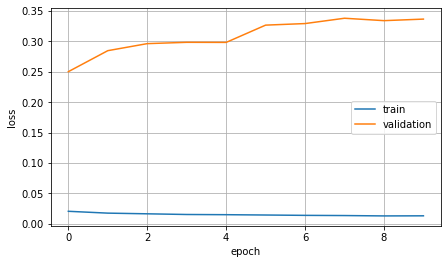

In [66]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

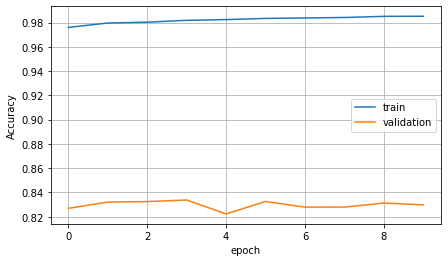

In [67]:
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

In [59]:
train_pred = model.predict([train_text, train_sentiment])
train_pred = np.squeeze(train_pred)
train_pred = np.round(train_pred)
train_pred.shape

(23099, 27)

In [60]:
pred = []
for vector in train_pred:
    index = []
    for i, value in enumerate(vector):
        if value == 1:
            index.append(i)
    pred.append(np.array(index))
print(len(pred))

23099


In [61]:
X_train['prediction'] = pred
pred_text = X_train[['clean_text', 'prediction']].apply(
    lambda x: get_text(x), axis=1)
X_train['pred_text'] = pred_text
X_train['pred_text'] = X_train['pred_text'].apply(lambda x: ' '.join(x))
X_train.head()

,textID,clean_text,clean_selected,sentiment,prediction,pred_text,jaccard
14624,81c29a90cd,actual gonna need new job want,actual gonna need new job want,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",actual gonna need new job want,1.0
9165,4df8509eb1,watching videos youtube funny david oh talente...,watching videos youtube funny david oh talente...,positive,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",watching videos youtube funny david oh talente...,1.0
4372,24ad015348,dat time boss text saying tweet n office dis t...,dat time boss text saying tweet n office dis t...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",dat time boss text saying tweet n office dis t...,1.0
14363,25c71e1832,poor mom told looked like skirt short degrees,looked like,negative,"[2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",told looked like skirt,0.5
15622,c4ee657cd2,mmmmm someone inside brlliant,mmmmm someone inside brlliant,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",mmmmm someone inside brlliant,1.0


In [68]:
X_train['jaccard'] = X_train.apply(
    lambda x: jaccard(x.clean_selected, x.pred_text), axis=1)
print('Mean training Jaccard score:', np.mean(X_train['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:', np.mean(
    X_train[X_train['sentiment'] == 'positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets', np.mean(
    X_train[X_train['sentiment'] == 'negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets', np.mean(
    X_train[X_train['sentiment'] == 'neutral']['jaccard']))

Mean training Jaccard score: 0.9400796923064231
Mean jaccard score for positive sentiment tweets: 0.9009403646380313
Mean jaccard score for negative sentiment tweets 0.9294784615187924
Mean jaccard score for neutral sentiment tweets 0.9775389503989407


In [52]:
valid_pred = model.predict([valid_text, valid_sentiment])
valid_pred = np.squeeze(valid_pred)
valid_pred = np.round(valid_pred)
valid_pred.shape

(4077, 27)

In [53]:
pred = []
for vector in valid_pred:
    index = []
    for i, value in enumerate(vector):
        if value == 1:
            index.append(i)
    pred.append(np.array(index))
print(len(pred))

4077


In [54]:
X_valid['prediction'] = pred
pred_text = X_valid[['clean_text', 'prediction']].apply(
    lambda x: get_text(x), axis=1)
X_valid['pred_text'] = pred_text
X_valid['pred_text'] = X_valid['pred_text'].apply(lambda x: ' '.join(x))
X_valid.head()

,textID,clean_text,clean_selected,sentiment,prediction,pred_text
24747,3d13b826a7,http twitpic com thx capacity bought second hand,thx capacity bought second,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",http twitpic com thx capacity bought second hand
14528,4b38f22fb7,awww sucks,sucks,negative,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",sucks
25706,5feecc0367,total love lip ring piercings ut favorite,total love,positive,"[1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",love favorite
6253,b58106c8bd,world makes sad,sad,negative,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",sad
13077,757b11e355,wow shabu himym really feels comforting,comforting,positive,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",himym really feels comforting


In [55]:
X_valid['jaccard'] = X_valid.apply(
    lambda x: jaccard(x.clean_selected, x.pred_text), axis=1)
print('Mean training Jaccard score:', np.mean(X_valid['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:', np.mean(
    X_valid[X_valid['sentiment'] == 'positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets', np.mean(
    X_valid[X_valid['sentiment'] == 'negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets', np.mean(
    X_valid[X_valid['sentiment'] == 'neutral']['jaccard']))

Mean training Jaccard score: 0.6739200563152
Mean jaccard score for positive sentiment tweets: 0.47728059422770924
Mean jaccard score for negative sentiment tweets 0.48253651730214253
Mean jaccard score for neutral sentiment tweets 0.9703418989221844


In [ ]:
X_valid

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
conf = confusion_matrix(y_valid,pred)
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(conf), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')